In [157]:
import copy
import os
import pickle
from typing import NamedTuple, List, Tuple

import matplotlib
import numpy
import torch
from matplotlib import pyplot

from tom.learners import SinusoidalLearner
from tom.mpl_extension import axes_iter
from tom.sinusoid import Batch, DEFAULT_INPUT_RANGE, generate_sinusoid_batch, batch_to_x_y, get_prediction_mse
from tom.torch_extension import module_device, module_eval

In [158]:
# Set the figure background to be solid white (default is transparent). This makes plots
# readable when using dark themes in PyCharm.
matplotlib.rcParams['figure.facecolor'] = (1, 1, 1, 1)

def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(DEFAULT_INPUT_RANGE[0], DEFAULT_INPUT_RANGE[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*DEFAULT_INPUT_RANGE)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

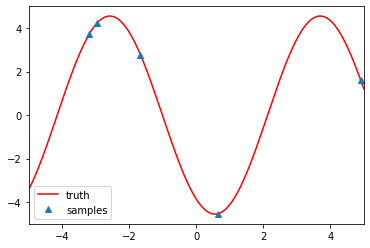

In [159]:
def _test_plotting():
    batch = generate_sinusoid_batch(3, 5)
    plot_task(batch, 0)

_test_plotting()

In [160]:
def load_trained_module(module: torch.nn.Module, name: str) -> List[float]:
    """Load the saved parameters of a module into the specified module, and return the MSEs got from training."""
    # Restore the module parameters from disk.
    module.load_state_dict(torch.load(os.path.join('trained_models', f'sinusoid_{name}.pt')))

    # Load the MSEs from training
    with open(os.path.join('trained_models', f'sinusoid_{name}_train_mse.pkl'), 'rb') as file_:
        return pickle.load(file_)

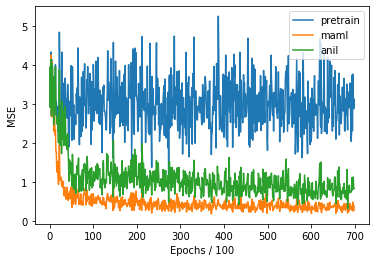

In [161]:
module_pretrain = SinusoidalLearner()
pretrain_mses = load_trained_module(module_pretrain, 'pretrain_70k')

module_maml = SinusoidalLearner()
maml_mses = load_trained_module(module_maml, 'maml_70k')

module_anil = SinusoidalLearner()
anil_mses = load_trained_module(module_anil, 'anil_70k')

pyplot.figure()
pyplot.xlabel('Epochs / 100')
pyplot.ylabel('MSE')
pyplot.plot(pretrain_mses, label='pretrain')
pyplot.plot(maml_mses, label='maml')
pyplot.plot(anil_mses, label='anil')
pyplot.legend()
pyplot.show()

In [162]:
def _train_step(module: torch.nn.Module, train_batch: Batch, optimizer):
    loss = get_prediction_mse(module, train_batch)

    # Zero gradients, perform a backward pass (compute gradients wrt. the loss), and update the 
    # weights accordingly.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

def _get_prediction(module: torch.nn.Module, x: numpy.ndarray) -> numpy.ndarray:
    device = module_device(module)
    torch_x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad(), module_eval(module):
        torch_y = module(torch_x)
    return torch_y.cpu().numpy().squeeze(1)
    
    
class BatchPrediction(NamedTuple):
    y: numpy.ndarray
    mse_loss: float

    
def _get_test_prediction(module, test_batch: Batch) -> BatchPrediction:
    """Get the prediction when evaluating the module on the given batch."""
    device = module_device(module)
    x, y = batch_to_x_y(test_batch, device)

    # No need to accumulate gradients when evaluating the validation loss.
    # Also, we put the model into "evaluation mode" for the purpose of computing the prediction.
    # This is to prevent layers like BatchNorm / Dropout mutating their internal state.
    with torch.no_grad(), module_eval(module):
        y_pred = module(x)
        test_mse = torch.nn.functional.mse_loss(y_pred, y).item()
        
    return BatchPrediction(y_pred.cpu().numpy().squeeze(1), test_mse)


In [163]:
def meta_test_batch(
        module: torch.nn.Module,
        batch: Batch,
        learning_rate: float,
        base_color: str,
        only_tune_final_layer: bool):
    # We need to make an independent copy of the module's parameters before we mutate them in training.
    # This seems like an incredibly blunt way of achieving this, but it seems to work.
    module = copy.deepcopy(module)
    
    test_x = numpy.linspace(DEFAULT_INPUT_RANGE[0], DEFAULT_INPUT_RANGE[1])
    
    y = _get_prediction(module, test_x)
    
    plot_task(batch, 0)
    pyplot.plot(test_x, y, '-', c=f'light{base_color}', ls='dotted', alpha=0.75, label='pre-update')
    
    # Now perform a small number of learning updates on the batch, plotting how our prediction evolves.
    if only_tune_final_layer:
        optimizer = torch.optim.SGD(list(module.layers[-1].parameters()), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(module.parameters(), lr=learning_rate)

    _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c=base_color, ls='dotted', alpha=0.75, label='1 grad step')
    
    for _ in range(9):
        _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c=base_color, ls='-.', alpha=1., label='10 grad steps')

    batch_size_inner = batch.x.shape[1]
    pyplot.title(f'K = {batch_size_inner}, LR = {learning_rate}')
    pyplot.legend()
    pyplot.tight_layout()

    
def meta_test(
        module,
        *,
        batch_size_inner: int = 10,
        input_range: tuple = DEFAULT_INPUT_RANGE,
        learning_rate: float = 0.001,
        base_color: str = 'blue'):
    """Perform a single test on the trained module"""
    # A batch of data on which we shall be testing.
    batch = generate_sinusoid_batch(1, batch_size_inner, input_range=input_range)
    meta_test_batch(module, batch, learning_rate, base_color, False)

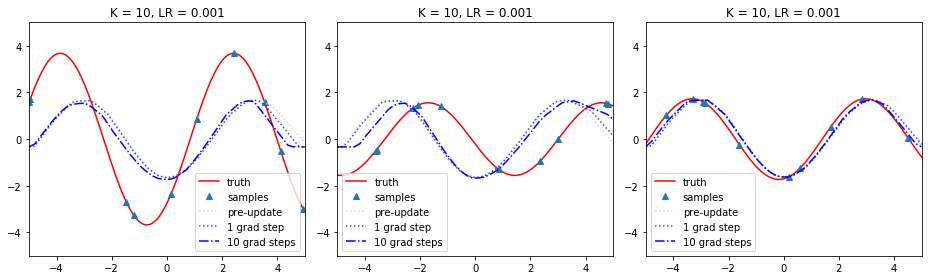

In [164]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain)

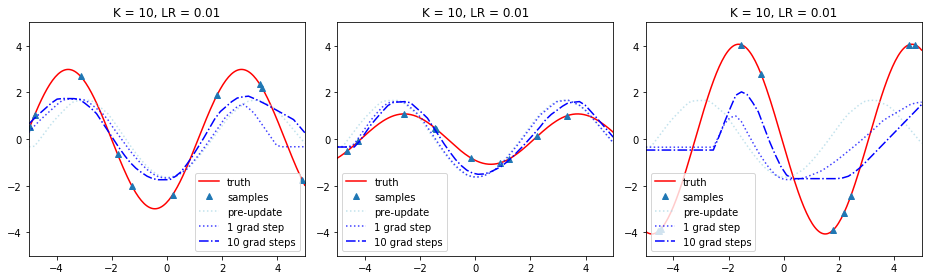

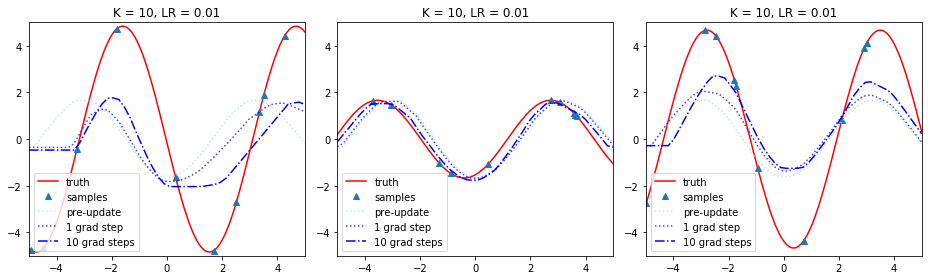

In [165]:
for _ in axes_iter(range(6)):
    meta_test(module_pretrain, learning_rate=0.01)

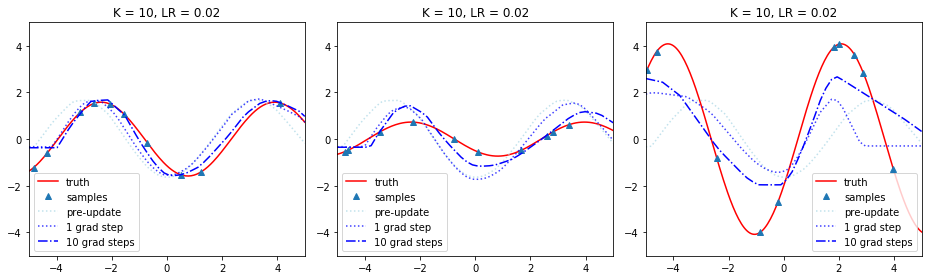

In [166]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain, learning_rate=0.02)

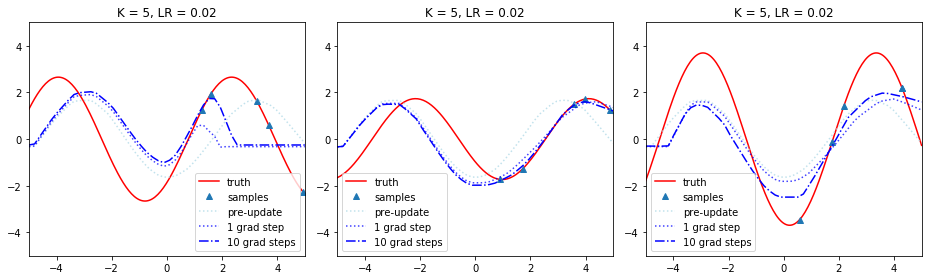

In [167]:
for _ in axes_iter(range(3)):
    meta_test(module_pretrain, batch_size_inner=5, input_range=(0, 5), learning_rate=0.02)

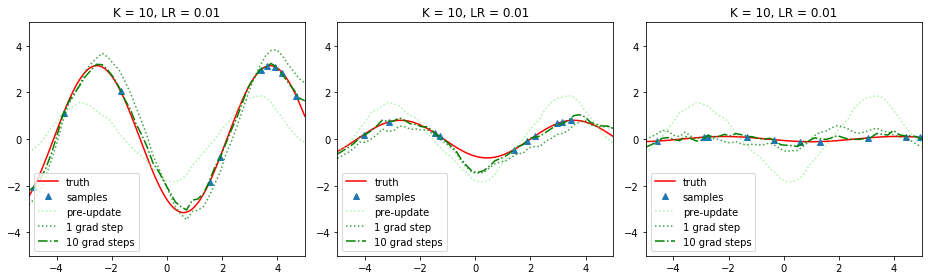

In [168]:
for _ in axes_iter(range(3)):
    meta_test(module_maml, learning_rate=0.01, base_color='green')

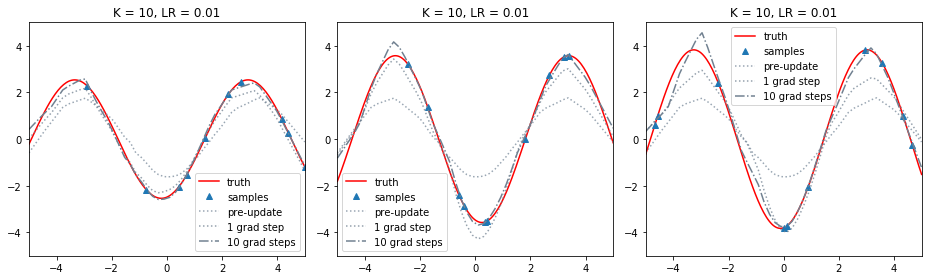

In [169]:
for _ in axes_iter(range(3)):
    meta_test(module_anil, learning_rate=0.01, base_color='slategrey')

In [170]:
def meta_test_multi(
        configs: List[Tuple[torch.nn.Module, str, bool]],
        *,
        batch_size_inner: int = 10,
        input_range: tuple = DEFAULT_INPUT_RANGE,
        learning_rate: float = 0.01):
    """Perform a single test on the trained module"""
    batch = generate_sinusoid_batch(1, batch_size_inner, input_range=input_range)
    for (module, color, only_tune_final_layer) in axes_iter(configs):
        meta_test_batch(module, batch, learning_rate, base_color=color, only_tune_final_layer=only_tune_final_layer)

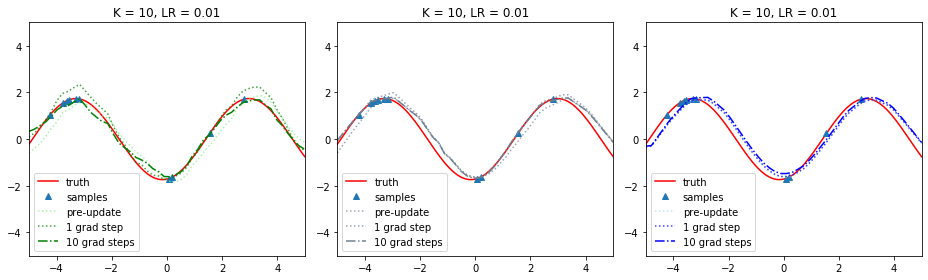

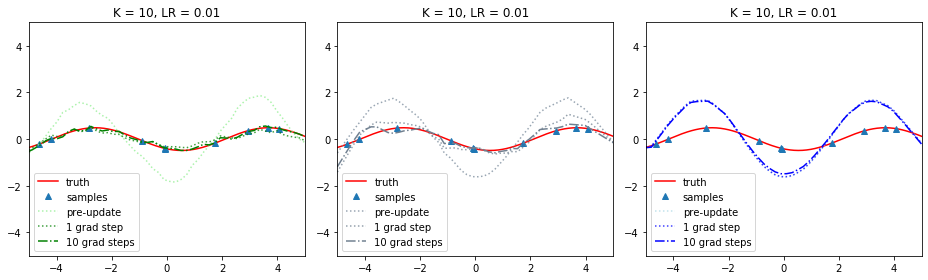

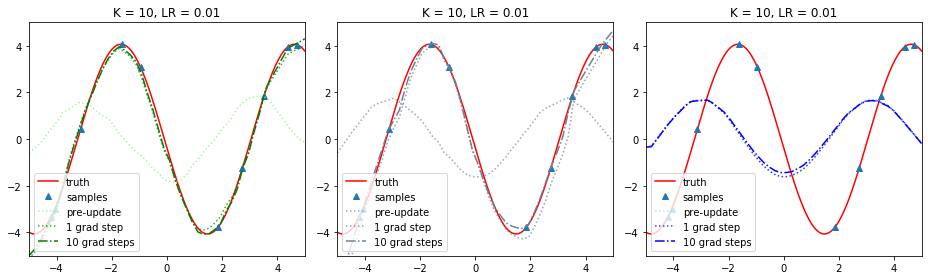

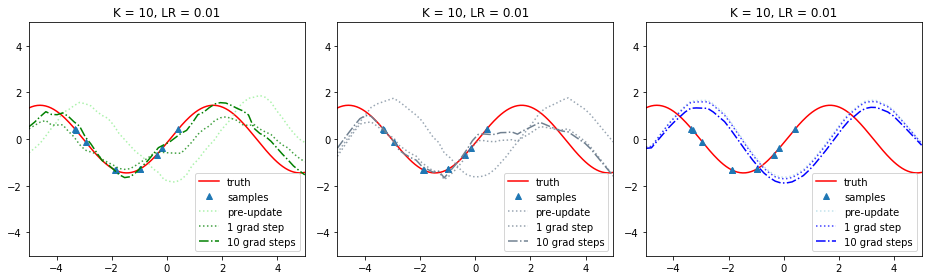

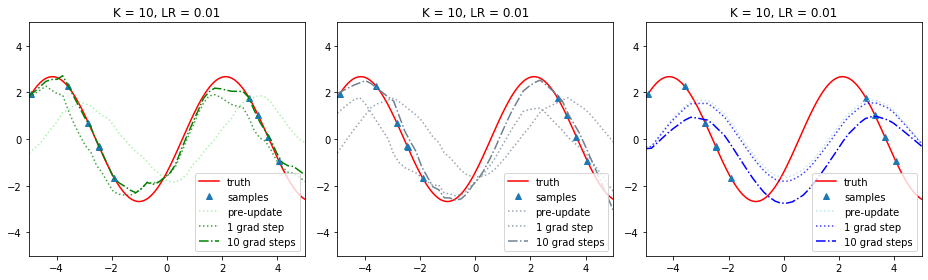

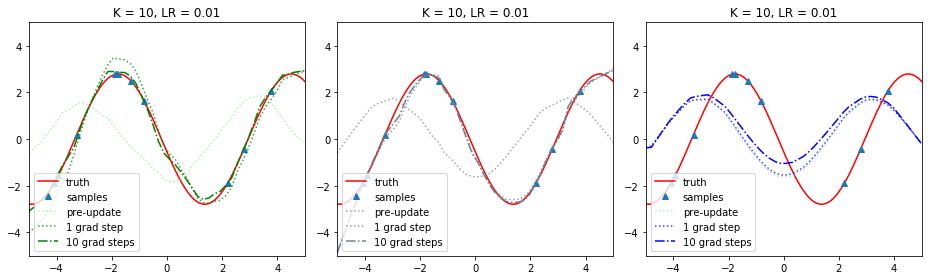

In [171]:
for _ in range(6):
    meta_test_multi(
        [(module_maml, 'green', False), (module_anil, 'slategrey', False), (module_pretrain, 'blue', True)],
        learning_rate=0.01)

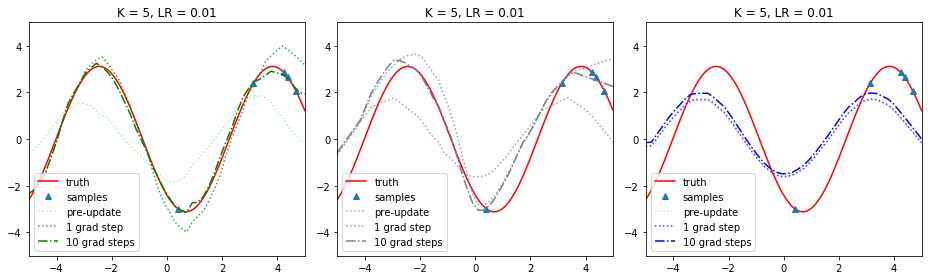

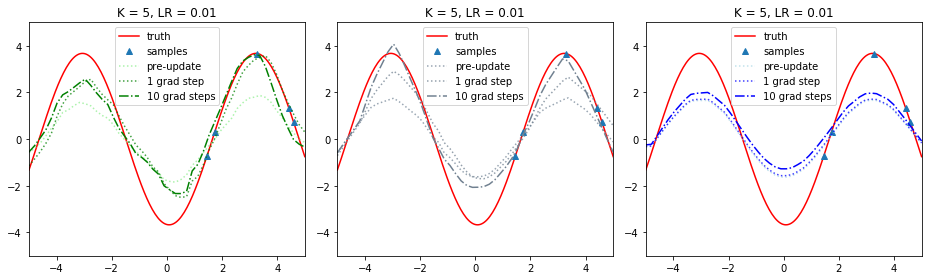

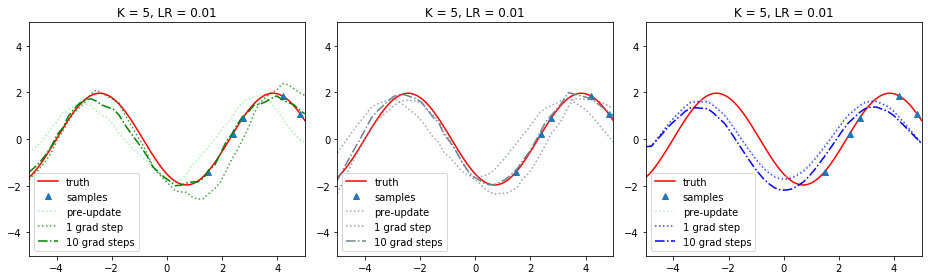

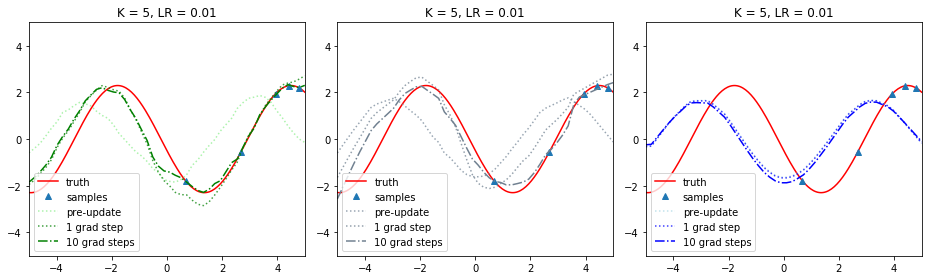

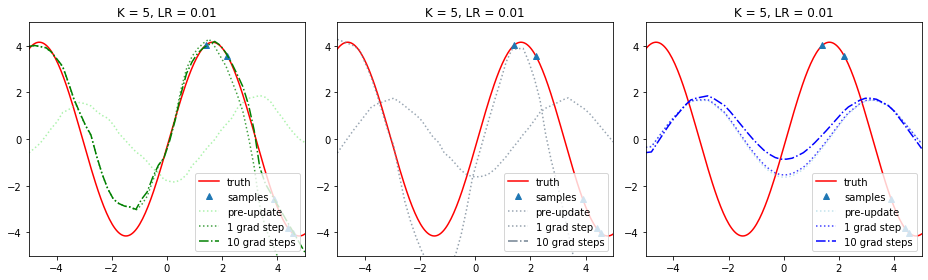

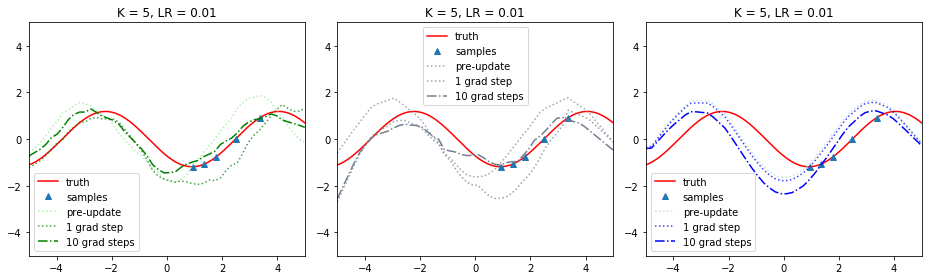

In [172]:
for _ in range(6):
    meta_test_multi(
        [(module_maml, 'green', False), (module_anil, 'slategrey', False), (module_pretrain, 'blue', True)],
        learning_rate=0.01,
        batch_size_inner=5,
        input_range=(0, 5))